In [1]:
# !pip install datasets
#!pip install pydot

In [61]:
# What version of Python do you have?
import seaborn as sns
import sys
import os
import tensorflow.keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensor Flow Version: 2.9.1
Keras Version: 2.9.0
Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.2
GPU is available


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, dot, Dropout , LSTM, Bidirectional, Flatten, Concatenate, GRU
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [3]:
data_folder = 'data'
main_dir = os.getcwd()
data_dir = os.path.join(main_dir, data_folder)

try:
    os.mkdir(data_dir)
    print(f"Directory '{data_folder}' created")
except:
    print(f"Directory '{data_folder}' already exists")

Directory 'data' already exists


In [4]:
os.chdir(data_dir)
print(f'Base directory changed to: {data_dir}')

Base directory changed to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3\data


In [5]:
# !git clone https://huggingface.co/datasets/fgrezes/WIESP2022-NER

In [6]:
os.chdir(main_dir)
print(f'Base directory changed back to: {main_dir}')

Base directory changed back to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3


In [7]:
data_name = 'WIESP2022-NER-TRAINING.jsonl'
data_path = os.path.join(data_dir, "WIESP2022-NER",data_name)
ner_df = pd.read_json(data_path, lines =True)

In [8]:
ner_df.head()

,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,2018MNRAS.478.5533F,1129,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F
2,2018MNRAS.480.3062L,1086,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
3,2016MNRAS.457.1786M,1135,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...",acknowledgments,"[BDM, gratefully, acknowledges, support, from,...",acknowledgments_1135_2016MNRAS.457.1786M
4,2019MNRAS.482L...9B,559,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B


In [10]:
def word_to_num(df, token_col):
    count = 1
    word_to_id = {}
    token_id_col = []
    for i, row in df.iterrows():
        token_id_list = []
        for token in row[token_col]:
            if token not in word_to_id:
                word_to_id[token] = count
                count += 1
            
            token_id = word_to_id[token]
            token_id_list.append(token_id)
        token_id_col.append(token_id_list)
    word_to_id['PAD'] = 0
    id_to_word = {v:k for k, v in word_to_id.items()}
    return word_to_id, id_to_word, token_id_col

In [11]:
ner_df.shape

(1753, 7)

In [12]:
word_to_id, id_to_word, token_id_col = word_to_num(ner_df, 'tokens')

In [13]:
# create the token_ids column
ner_df['token_ids'] = token_id_col
ner_df.head(2)

,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id,token_ids
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2018MNRAS.478.5533F,1129,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F,"[256, 257, 7, 258, 259, 23, 7, 260, 77, 261, 2..."


In [63]:
ner_dist = {}

for i, row in ner_df.iterrows():
    for ner in row['ner_tags']:
        if ner in ner_dist:
            ner_dist[ner] += 1

        else:
            ner_dist[ner] = 1
        
ner_dist = {key:val for key, val in dist_df.items() if key != 'O'}
    

In [64]:
top_20_ner = [k for k, v in sorted(ner_dist.items(), key=lambda item: item[1], reverse = True)][:20]

TypeError: '<' not supported between instances of 'str' and 'int'

In [59]:
top_20_ner_dist = {n:ner_dist[n] for n in top_20_ner}

In [60]:
top_20_ner_dist

{'O': 472307,
 'I-Citation': 18402,
 'I-Organization': 14211,
 'I-Formula': 8433,
 'B-Organization': 7448,
 'B-Citation': 6360,
 'I-Grant': 4080,
 'B-Person': 3916,
 'B-Grant': 3478,
 'B-Wavelength': 3384,
 'B-CelestialObject': 2940,
 'I-Person': 2206,
 'B-Formula': 2088,
 'B-Model': 1800,
 'I-CelestialObject': 1691,
 'I-Wavelength': 1583,
 'B-Telescope': 1573,
 'B-Location': 1404,
 'I-Model': 1244,
 'I-Observatory': 1035}

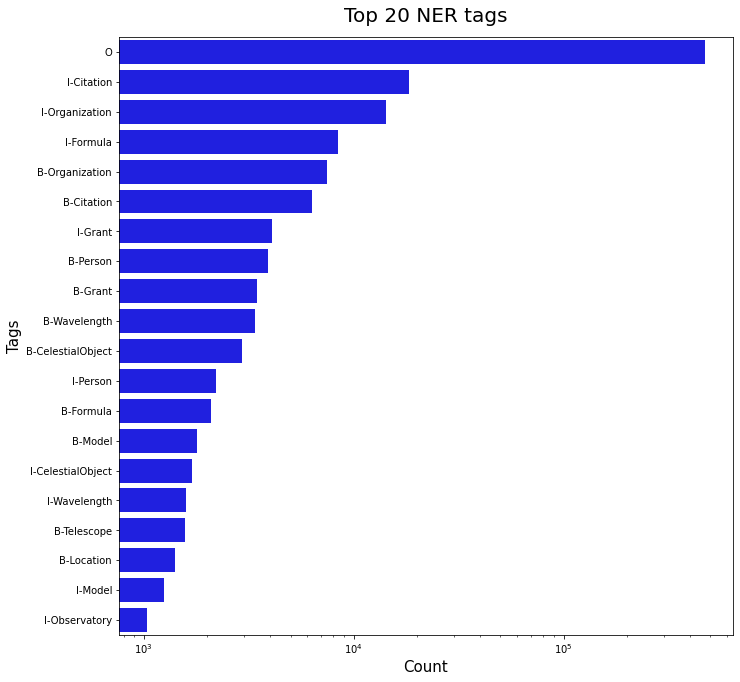

In [67]:
#create dist dataframe
dist_df = pd.DataFrame()
dist_df["tags"] = list(top_20_ner_dist.keys())
dist_df["count"] = list(top_20_ner_dist.values())

#sort the data
dist_df.sort_values("count", ascending = False, inplace = True)

# Plot the feature importance
fig, ax = plt.subplots(figsize=(11,11))
sns.set_color_codes("pastel")
sns.barplot(x = 'count',y = 'tags', data=dist_df, color="Blue", ax = ax)
ax.set_xscale("log")
ax.set_xlabel("Count", fontsize = 15)
ax.set_ylabel("Tags", fontsize = 15)
ax.set_title("Top 20 NER tags", fontsize = 20, pad = 15)
plt.show()

In [14]:
embed_data = ner_df.explode('token_ids').reset_index()[['token_ids']].values.flatten().tolist()

In [15]:
# Train custom embedding

window_size = 3
vocab_size = len(list(word_to_id.keys())) + 1
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size = vocab_size)

couples, labels = skipgrams(sequence = embed_data,
                            vocabulary_size = vocab_size,
                            window_size = window_size,
                            sampling_table = sampling_table
                            )
word_center, word_context = zip(*couples)


In [16]:
# Embedding Dimention
vector_dim = 30
# target embedding
word_model = Sequential()
word_model.add(Embedding(input_dim = vocab_size, \
                         output_dim = vector_dim, \
                         input_length = 1, \
                         name = 'word_embedding'))
word_model.add(Reshape((vector_dim,)))

# context embedding
context_model = Sequential()
context_model.add(Embedding(input_dim = vocab_size, \
                           output_dim = vector_dim, \
                           input_length = 1, \
                           name = 'context_embedding'))
context_model.add(Reshape((vector_dim,)))

# dotproduct
dot_product = dot([word_model.output, context_model.output], axes = 1, name = 'dot_product')
sigmoid_dot_product = Dense(1, activation = 'sigmoid')(dot_product)

# Word2Vec model
w2v_model = Model(inputs = [word_model.input, context_model.input], outputs = sigmoid_dot_product, name = 'w2v_model')
               
# Summary
w2v_model.summary()

Model: "w2v_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_embedding_input (InputLay  [(None, 1)]         0           []                               
 er)                                                                                              
                                                                                                  
 context_embedding_input (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 word_embedding (Embedding)     (None, 1, 30)        1469790     ['word_embedding_input[0][0]']   
                                                                                          

In [17]:
word_arr = np.array(word_center, dtype = 'float32')
context_arr = np.array(word_context, dtype = 'float32')
labels_arr = np.array(labels, dtype = 'float32')

In [18]:
w2v_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
model_folder = 'model'
main_dir = os.getcwd()
model_dir = os.path.join(main_dir, model_folder)

try:
    os.mkdir(model_dir)
    print(f"Directory '{model_folder}' created")
except:
    print(f"Directory '{model_folder}' already exists")

Directory 'model' already exists


In [20]:
w2v_folder = 'w2v'
w2v_dir = os.path.join(main_dir, model_folder, w2v_folder)

try:
    os.mkdir(w2v_dir)
    print(f"Directory '{w2v_folder}' created")
except:
    print(f"Directory '{w2v_folder}' already exists")

Directory 'w2v' already exists


In [21]:
os.chdir(w2v_dir)
print(f'Base directory changed to: {w2v_dir}')

Base directory changed to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3\model\w2v


In [22]:
# batch_size = 256

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('.w2v_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
# num_epochs = 20


# w2v_model.fit([word_arr, context_arr], labels_arr, batch_size=batch_size, epochs=num_epochs, callbacks=[early_stopping, mcp_save, reduce_lr_loss], validation_split = 0.25)

In [23]:
os.chdir(main_dir)
print(f'Base directory changed back to: {main_dir}')

Base directory changed back to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3


In [24]:
os.chdir(w2v_dir)
print(f'Base directory changed to: {w2v_dir}')

Base directory changed to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3\model\w2v


In [25]:
w2v_model.load_weights('.w2v_wts2.hdf5')

In [26]:
os.chdir(main_dir)
print(f'Base directory changed back to: {main_dir}')

Base directory changed back to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3


In [27]:
w2v_embedding = w2v_model.get_layer('word_embedding').get_weights()[0]

In [28]:
w2v_embedding.shape

(48993, 30)

In [29]:
def transform_pad(data_input, data_output):
    # Pad the inputs
    input_pad = data_input.to_tensor(default_value=0, shape=[None, None])
    # Pad the outputs
    output_pad = data_output.to_tensor(default_value=0, shape=[None, None])
    
    return input_pad, output_pad

In [30]:
def make_dataframe(data, token_id_col, ner_col, word_to_id, batch_size = 64):
    '''
    Preparing our data for training
    '''
    batch_size = batch_size
    shuffle_buffer_size = data.shape[0]
    X = data[token_id_col].values
    y = data[ner_col].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    # Use tensorflow ragged constants to get the ragged version of data
    X_train_processed = tf.ragged.constant(list(X_train))
    y_train_processed = tf.ragged.constant(list(y_train))
    X_val_processed = tf.ragged.constant(list(X_val))
    y_val_processed = tf.ragged.constant(list(y_val))

    # Create TF Dataset
    tf_train_data = tf.data.Dataset.from_tensor_slices((X_train_processed, y_train_processed))
    tf_val_data = tf.data.Dataset.from_tensor_slices((X_val_processed, y_val_processed))
    #############
    # Train data
    #############
    # Apply all data processing logic
    tf_train_data = tf_train_data.shuffle(buffer_size = shuffle_buffer_size)
    tf_train_data = tf_train_data.batch(batch_size)
    tf_train_data = tf_train_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
    tf_train_data = tf_train_data.prefetch(AUTOTUNE)
    
    #tf_val_data = tf_val_data.shuffle(buffer_size = shuffle_buffer_size)
    tf_val_data = tf_val_data.batch(batch_size)
    tf_val_data = tf_val_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
    tf_val_data = tf_val_data.prefetch(AUTOTUNE)
    return tf_train_data, tf_val_data

In [31]:
# batch_size = 64
# train_data, val_data = make_dataframe(ner_df, 'token_ids', 'ner_ids', word_to_id, batch_size)

In [32]:
X = ner_df['token_ids'].values
y = ner_df['ner_ids'].values

X_idx = ner_df['token_ids'].index
y_idx = ner_df['ner_ids'].index
    
train_idx, val_idx = train_test_split(X_idx, test_size=0.25)

In [33]:
X_train, X_val, y_train, y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]

In [34]:
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post')
y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post')
y_val_padded = tf.keras.preprocessing.sequence.pad_sequences(y_val, padding='post')

In [35]:
rnn_folder = 'rnn_model'
rnn_dir = os.path.join(main_dir, model_folder, rnn_folder)

try:
    os.mkdir(rnn_dir)
    print(f"Directory '{rnn_folder}' created")
except:
    print(f"Directory '{rnn_folder}' already exists")

Directory 'rnn_model' already exists


In [36]:
def make_model(hidden_size, num_layers, bidir = False):
    tf.keras.backend.clear_session()
    sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

    word_embedding = tf.keras.layers.Embedding(input_dim=embed_matrix.shape[0], output_dim=embed_matrix.shape[1],\
                    name='word_embedding', mask_zero=True)
    masked_embeddinbg = word_embedding(sentence_input1)
    
    h_f = []
    h_b = []
    # First Forward RNN layer
    RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
    hf = RNN(masked_embeddinbg)
    h_f.append(hf)
    if bidir:
        RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
        hb = RNN(masked_embeddinbg)
        h_b.append(hb)
        

    # Create forward RNNs
    for k in range(1,num_layers):
        RNN_f = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
        hf = RNN_f(hf)
        h_f.append(hf)

        if bidir:
            RNN_b = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
            hb = RNN_b(hb)
            h_b.append(hb)
    
    if bidir:
        if num_layers==1:
            h = tf.keras.layers.concatenate([hf, hb])        
        else:
            h = tf.keras.layers.concatenate(h_f+h_b)
    else:
        if num_layers==1:
            h = h_f[0]
        else:
            h = tf.keras.layers.concatenate(h_f)
          
    
    dense = tf.keras.layers.Dense(embed_matrix.shape[0], activation='softmax')
    output = dense(h)

    model = tf.keras.Model(inputs=sentence_input1, outputs=output, \
          name='_'.join([str(hidden_size), str(num_layers),str(bidir)]))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
    
    return model

In [37]:
hidden_size = 15
num_layers = 1
embed_matrix = w2v_embedding
rnn_model = make_model(hidden_size, num_layers, bidir = False)
rnn_model.summary()

Model: "15_1_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, None)]           0         
                                                                 
 word_embedding (Embedding)  (None, None, 30)          1469790   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 15)          690       
                                                                 
 dense (Dense)               (None, None, 48993)       783888    
                                                                 
Total params: 2,254,368
Trainable params: 784,578
Non-trainable params: 1,469,790
_________________________________________________________________


In [38]:
os.chdir(rnn_dir)
print(f'Base directory changed to: {rnn_dir}')

Base directory changed to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3\model\rnn_model


In [39]:
tf.keras.utils.plot_model(two_rnn_model, to_file='simple_rnn.png', show_shapes=True)

NameError: name 'two_rnn_model' is not defined

In [40]:
# mcp_save_2 = ModelCheckpoint('rnn_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# num_epochs_2 = 20

# history_two_rnn = two_rnn_model.fit(X_train_padded, y_train_padded, validation_data = (X_val_padded, y_val_padded), epochs=num_epochs_2, callbacks=[mcp_save_2])

In [41]:
os.chdir(main_dir)
print(f'Base directory changed back to: {main_dir}')

Base directory changed back to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3


In [42]:
os.chdir(rnn_dir)
print(f'Base directory changed to: {rnn_dir}')

Base directory changed to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3\model\rnn_model


In [43]:
rnn_model.load_weights('rnn_wts.hdf5')

In [44]:
os.chdir(main_dir)
print(f'Base directory changed back to: {main_dir}')

Base directory changed back to: C:\Users\kandp\OneDrive\Documents\Univ_proj\AI-3


In [65]:
rnn_model.predict(X_val_padded)

ResourceExhaustedError: Graph execution error:

Detected at node '15_1_False/dense/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\kandp\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\kandp\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\kandp\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\kandp\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\kandp\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\kandp\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\kandp\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\kandp\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\kandp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kandp\AppData\Local\Temp\ipykernel_17800\736025704.py", line 1, in <cell line: 1>
      rnn_model.predict(X_val_padded)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kandp\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 224, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: '15_1_False/dense/Tensordot/MatMul'
OOM when allocating tensor with shape[20576,48993] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node 15_1_False/dense/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_860]

In [46]:
hidden_size = 8
num_layers = 2
embed_matrix = w2v_embedding
rnn_baseline = make_model(hidden_size, num_layers, bidir = False)
rnn_baseline.summary()

Model: "8_2_False"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, None, 30)     1469790     ['sentence_input[0][0]']         
                                                                                                  
 simple_rnn (SimpleRNN)         (None, None, 8)      312         ['word_embedding[0][0]']         
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, None, 8)      136         ['simple_rnn[0][0]']             
                                                                                          

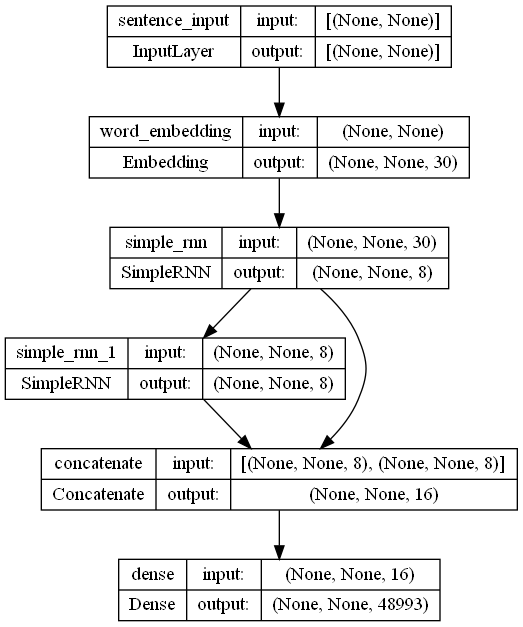

In [48]:
tf.keras.utils.plot_model(rnn_baseline, to_file='simple_rnn.png', show_shapes=True)